# Setup

## Install dependencies

In [1]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install --quiet pandas
!pip install --quiet seaborn
!pip install --quiet matplotlib
!pip install scikit-posthocs

## Loading Extensions and Configuring SQL Magic
These steps should be run in separate Jupyter Notebook cells:



In [2]:
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

In [3]:
# Configure SQL Magic (optional configurations)
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%config SqlMagic.named_parameters="enabled"

## Connecting to DuckDB
This cell establishes a connection to a DuckDB database file named `experiments.db` located at the root of your project directory. If the file doesn't exist, DuckDB will create it.

In [4]:
# Connect to DuckDB
%sql duckdb:///experiments.db

##  Using SQLAlchemy for More Complex Operations
This code creates an SQLAlchemy engine connected to the same DuckDB database. Note that the URI format is slightly different when used with `create_engine` from SQLAlchemy (`duckdb:///` instead of `duckdb://///`).

In [5]:
# Import necessary libraries and create an engine
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scikit_posthocs as posthocs

from coleman4hcs.statistics import vargha_delaney
from enum import Enum
from typing import List, Optional
from scipy.stats import kruskal
from sqlalchemy import create_engine

# For a beautiful plots
plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set(palette="pastel")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

engine = create_engine('duckdb:///experiments.db')

In [6]:
# Create/Open a database to store the results            
conn = duckdb.connect('experiments.db')

# Ensure the tables exist with the appropriate schema
conn.execute("""
CREATE TABLE IF NOT EXISTS experiments (
    scenario VARCHAR,
    experiment_id INTEGER,
    step INTEGER,
    policy VARCHAR,
    reward_function VARCHAR,
    sched_time FLOAT,
    sched_time_duration FLOAT,
    total_build_duration FLOAT,
    prioritization_time FLOAT,
    detected INTEGER,
    missed INTEGER,
    tests_ran INTEGER,
    tests_not_ran INTEGER,
    ttf FLOAT,
    ttf_duration FLOAT,
    time_reduction FLOAT,
    fitness FLOAT,
    cost FLOAT,
    rewards FLOAT,
    avg_precision FLOAT,
    prioritization_order VARCHAR
);
""")

# Pre-processing data

We can filter the desired data.

In this analysis, for easy presentation, we will consider only the MAB policies executed with the reward function named Time-ranked Reward.

In [7]:
%%sql 
CREATE OR REPLACE TABLE filtered_data AS
select 
       scenario,
       experiment_id,
       step,
       policy, 
       reward_function, 
       sched_time,
       sched_time_duration,
       total_build_duration,
       prioritization_time,
       ttf,
       ttf_duration,
       time_reduction,
       fitness,
       cost,
       avg_precision
from experiments 
where reward_function = 'Time-ranked Reward'

,Count
0,711060


Now, we update the policy names for better visualization/presentation/manipulation.

In [8]:
%%sql 
UPDATE filtered_data
SET policy = CASE WHEN policy LIKE 'ε-greedy (ε=0.5)' THEN 'ε-greedy'                  
                  WHEN policy LIKE 'UCB (C=0.5)' THEN 'UCB'                  
                  WHEN policy LIKE 'FRRMAB (C=0.5, D=1, SW=100)' THEN 'FRRMAB'
                  WHEN policy LIKE 'Greedy' THEN 'Greedy'
                  WHEN policy LIKE 'Softmax (Temperature=0.5)' THEN 'Softmax'
                  ELSE 'Random'
             END

,Count
0,711060


We also update the policy names for better visualization/presentation/manipulation.

In [9]:
%%sql 
UPDATE filtered_data
SET reward_function = CASE WHEN reward_function LIKE 'Time-ranked Reward' THEN 'TimeRank'                  
                           WHEN reward_function LIKE 'Reward Based on Failures' THEN 'RNFail'                  
                       END

,Count
0,711060


We define the RewardFunction enum to be used in the filters, if we want to do this.

In [10]:
class RewardFunction(Enum):
    """
    Enumeration for different types of reward functions.

    Attributes:
        TimeRank: Represents the "Time-ranked Reward" function.
        RNFail: Represents the "Reward Based on Failures" function.
    """
    TimeRank = "Time-ranked Reward"
    RNFail = "Reward Based on Failures"

# How we will manipulate the data
## Aggregating Data with SQL

Instead of loading the entire dataset into a Pandas DataFrame and then performing group-by operations, we will write SQL queries to aggregate the data within the database. 

This approach leverages the database's optimized computation capabilities.


# Analyzing the results

Now, we will analyze the results.
We created generic functions to analyze the results filtering by scenario and reward function.


## Initializing the main variables
In order to visualize the data, we need to identify:
- the scenarios in the data (experiment);
- MAB policies;
- the time budgets.


In [11]:
%%sql main_data <<
SELECT 
    distinct
    scenario,
    policy,
    sched_time,    
FROM filtered_data

In [12]:
scenarios = main_data['scenario'].unique()
policies = main_data['policy'].unique()
sched_times = main_data['sched_time'].unique()

For easy display based on the SQL column, the function below "translates" to the desired metric name.

In [13]:
def get_metric_ylabel(column, rw=None):
    """
    Determines the appropriate metric name and y-axis label based on the specified column.

    This function maps a given column name to its corresponding metric name and y-axis label
    for plotting purposes. It supports a predefined set of metrics commonly used in software
    testing and prioritization research, such as NAPFD, APFDc, RFTC, and custom reward functions.

    Parameters:
    - column (str): The name of the column for which the metric and y-axis label are determined.
                    Expected values include 'cost', 'ttf', 'prioritization_time', and 'rewards'.
    - rw (str, optional): The name of the custom reward function. This parameter is used only
                          when 'rewards' is specified in the column parameter. It allows for
                          custom labeling of the y-axis based on the reward function used.

    Returns:
    - tuple: A tuple containing two elements:
        - metric (str): The name of the metric corresponding to the specified column.
        - ylabel (str): The label for the y-axis when plotting the metric.

    Examples:
    >>> get_metric_ylabel('cost')
    ('APFDc', 'APFDc')
    >>> get_metric_ylabel('ttf')
    ('RFTC', 'Rank of the Failing Test Cases')
    >>> get_metric_ylabel('rewards', 'CustomReward')
    ('CustomReward', 'CustomReward')
    """
    metric = 'NAPFD'
    ylabel = metric
    if 'cost' in column:
        metric = 'APFDc'
        ylabel = metric
    elif 'ttf' in column:
        metric = 'RFTC'
        ylabel = 'Rank of the Failing Test Cases'
    elif 'prioritization_time' in column:
        metric = 'PrioritizationTime'
        ylabel = 'Prioritization Time (sec.)'
    elif 'rewards' in column:
        metric = rw
        ylabel = rw

    return metric, ylabel

# Plot Accumulative values across the CI Cycles
We summarize the performance across the experiments.

In [14]:
%%sql acc_data <<
SELECT     
    step, 
    scenario,
    policy, 
    sched_time,
    reward_function,
    SUM(fitness) OVER (PARTITION BY scenario, policy, sched_time, reward_function ORDER BY step) AS cum_fitness,
    SUM(cost) OVER (PARTITION BY scenario, policy, sched_time, reward_function ORDER BY step) AS cum_cost
FROM filtered_data
ORDER BY step, policy, sched_time;

In [15]:
def plot_accumulative(column: str, scenarios: Optional[List[str]] = None, reward_function: RewardFunction = None):
    """
    Plots the accumulative values of a specified metric for different policies across scheduled times.

    This function generates a series of subplots, each representing a different scheduled time,
    and plots the accumulative values of the specified metric for each policy within those times.
    It allows for filtering by specific scenarios if provided.

    Parameters:
    - column (str): The name of the column representing the metric to accumulate and plot.
                    This should be a column name in the global `acc_data` DataFrame.
    - scenarios (Optional[List[str]]): A list of scenario names to filter the data by before plotting.
                                       If None, all scenarios in the `acc_data` DataFrame are included.
    - reward_function (RewardFunction): The reward function to filter the data. If None, all reward functions are considered.

    The function uses the global `acc_data` DataFrame, which should contain the columns:
    'scenario', 'sched_time', 'policy', 'step', and the specified metric column.
    It also relies on the global `sched_times` list to determine the different scheduled times to plot.

    Each subplot will display the accumulative metric for each policy at a specific scheduled time,
    with policies represented as different lines within the plot.

    Note: This function assumes the existence of `acc_data` and `sched_times` in the global scope.
    """
    # Filter the data by scenario (if provided)     
    df_filtered = acc_data[acc_data['scenario'].isin(scenarios)] if scenarios else acc_data

    # Further filter the data by reward function (if provided)
    if reward_function:
        df_filtered = df_filtered[df_filtered['reward_function'] == reward_function.name]

    # Set up the figure and axes for the subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(sched_times), sharey=True, figsize=(15, 5))

    # Ensure axes is always an array, even when there's only one subplot
    if len(sched_times) == 1:
        axes = [axes]

    metric, _ = get_metric_ylabel(column)
    
    for ax, sched_time in zip(axes, sched_times):
        # Filter the DataFrame for the current sched_time
        df_sched_time_filtered = df_filtered[df_filtered['sched_time'] == sched_time]
        
        # Plotting each policy's accumulative fitness
        for name, group_df in df_sched_time_filtered.groupby('policy'):
            group_df.plot(x='step', y=column, ax=ax, label=name, linewidth=1)
        
        # Setting subplot titles and labels
        ax.set_title(f"Time Budget: {round(sched_time*100)}%")
        ax.set_xlabel('CI Cycle')
        ax.set_ylabel(f'Accumulative {metric}')
        ax.tick_params(axis='x', rotation=45)  # Optional: Rotate x-axis labels for readability        

    plt.tight_layout()
    plt.show()


## NAPFD

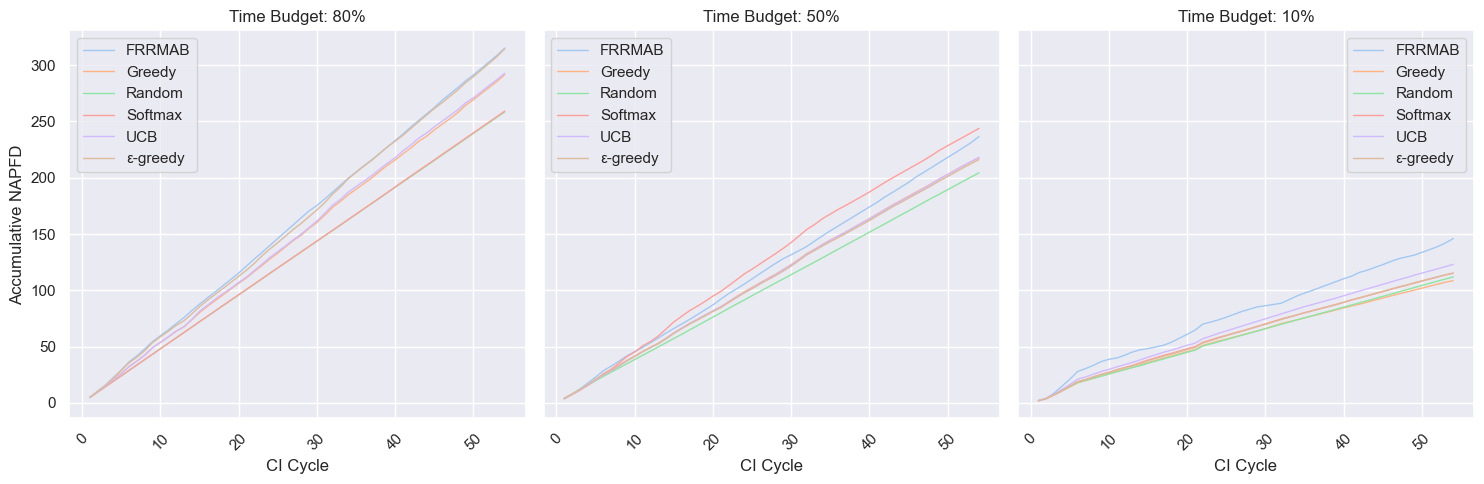

In [16]:
# Example of providing scenarios
plot_accumulative('cum_fitness', scenarios=['LexisNexis'], reward_function=RewardFunction.TimeRank)

## APFDc

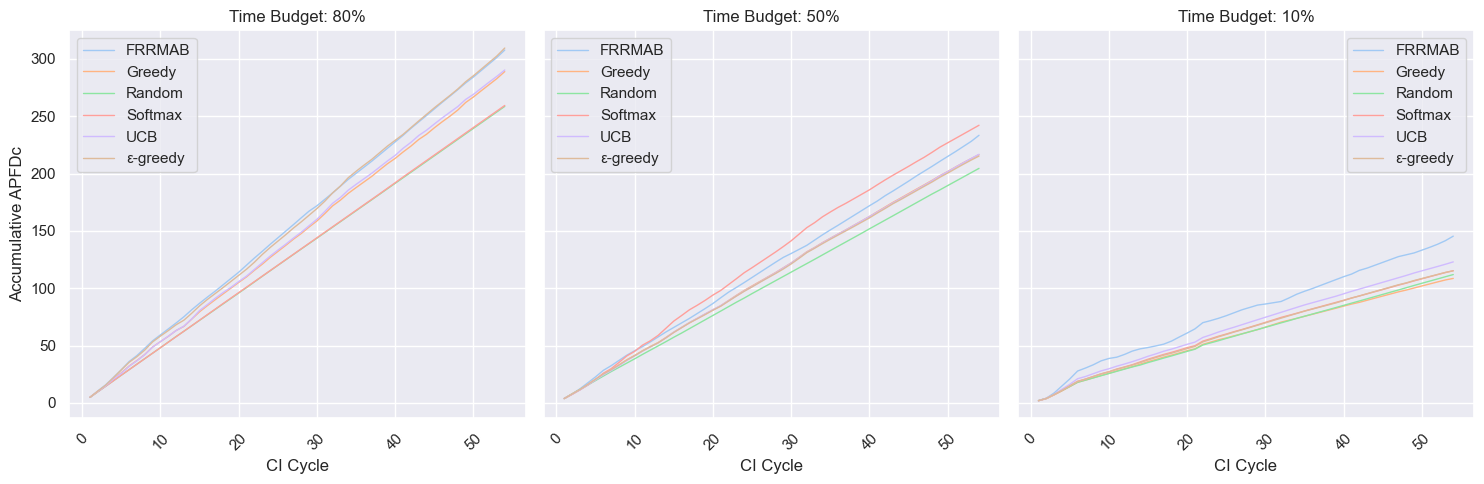

In [17]:
# Example of not providing scenarios
plot_accumulative('cum_cost', scenarios=['LexisNexis'], reward_function=RewardFunction.TimeRank)

# Plot Variation values across the CI Cycles
We calculate the average across all experiments.

In [18]:
%%sql variation_data <<
SELECT 
    scenario,
    step, 
    policy, 
    reward_function,
    AVG(fitness) AS fitness_variation,
    AVG(cost) AS cost_variation,
FROM filtered_data
GROUP BY scenario, step, policy, reward_function
ORDER BY scenario, step, policy, reward_function;

In [19]:
def plot_metric_variation(column: str, title: Optional[str] = None, scenarios: Optional[List[str]] = None, reward_function: RewardFunction = None):
    """
    Plots the variation of a specified metric per step for each policy.

    This function takes a DataFrame containing step-wise metric data for different policies
    and generates a line plot showing how the specified metric varies across steps for each policy.
    It allows for filtering by specific scenarios if provided.

    Parameters:    
    - column (str): The name of the metric column in `variation_data` to plot. This column should contain
                    the average values of the metric for each policy at each step.
    - title (Optional[str]): The title of the plot. If None, a default title will be generated based on the metric.
    - scenarios (Optional[List[str]]): A list of scenario names to filter the data by before plotting.
                                       If None, all scenarios in the `acc_data` DataFrame are included.
    - reward_function (RewardFunction): The reward function to filter the data. If None, all reward functions are considered.

    The function assumes `variation_data` is structured similarly to the output of the provided SQL query,
    with 'step' and 'policy' columns, plus at least one metric column indicating the variation of interest.
    """    
    # Filter the data by scenario (if provided)
    if scenarios:
        df_filtered = variation_data[variation_data['scenario'].isin(scenarios)]
    else:
        df_filtered = variation_data

    # Further filter the data by reward function (if provided)
    if reward_function:
        df_filtered = df_filtered[df_filtered['reward_function'] == reward_function.name]

    metric, _ = get_metric_ylabel(column)

    # Pivot the DataFrame to have policies as columns, steps as rows, and the specified metric as values
    pivot_df = df_filtered.pivot(index='step', columns='policy', values=column)

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 5))
    pivot_df.plot(ax=ax, linewidth=1)
    
    # Setting labels and title
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel(f'Average {metric}', fontsize=12)
    plot_title = title if title else f'Average {metric} per Step for Each Policy'
    ax.set_title(plot_title, fontsize=14)
    ax.legend(title='Policy')

    plt.tight_layout()
    plt.show()

## NAPFD

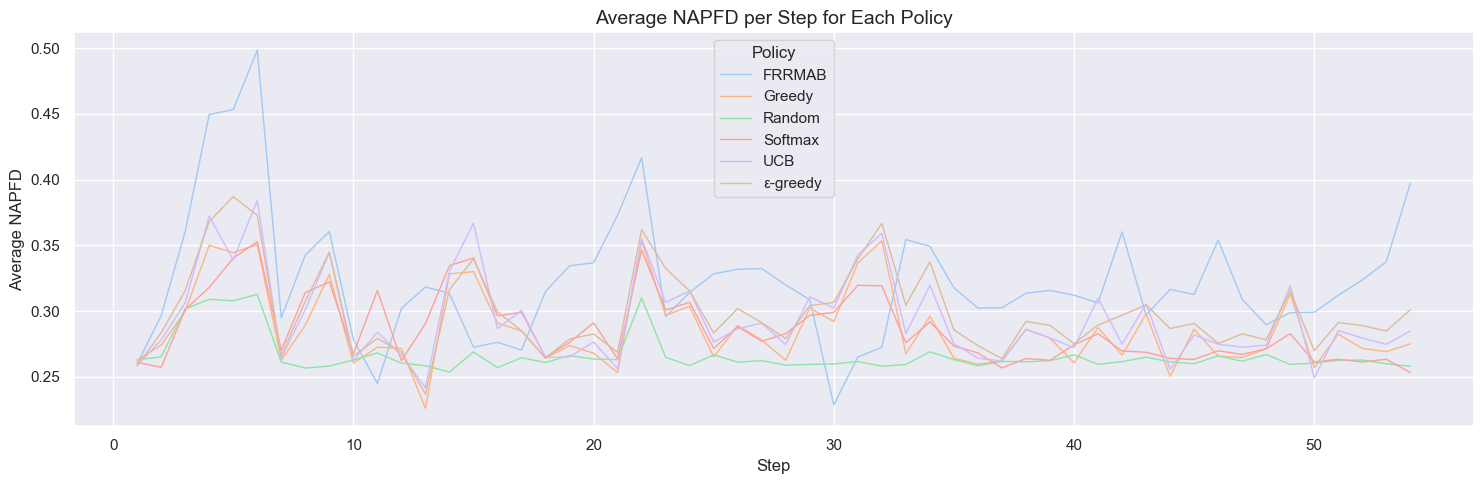

In [20]:
plot_metric_variation('fitness_variation', scenarios=['LexisNexis'], reward_function=RewardFunction.TimeRank)

## APFDc

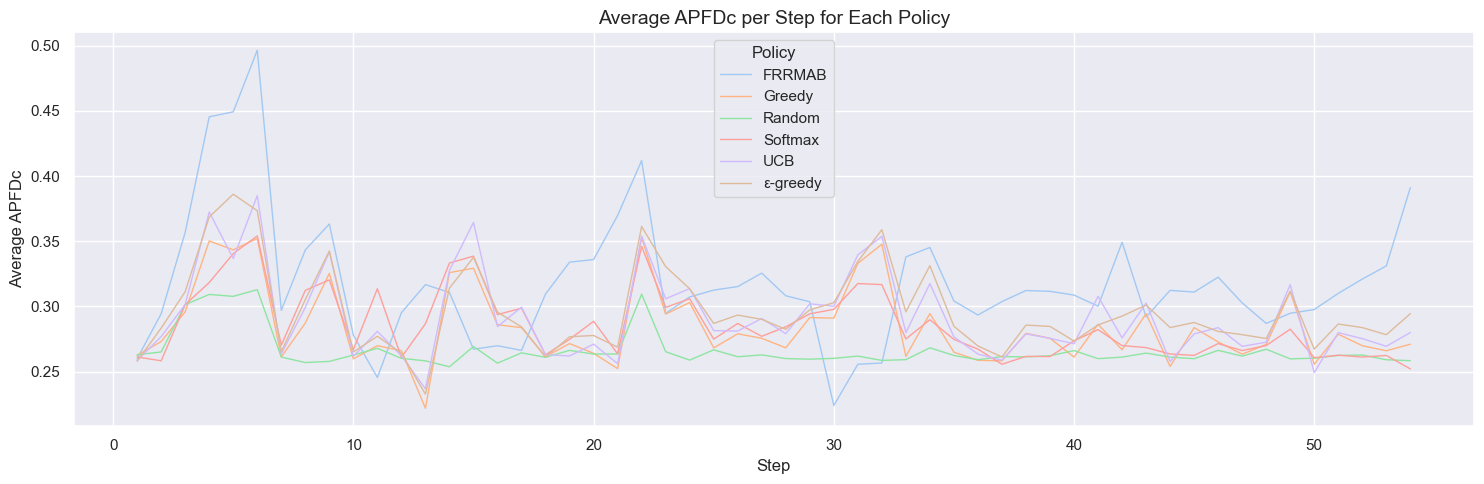

In [21]:
plot_metric_variation('cost_variation', scenarios=['LexisNexis'], reward_function=RewardFunction.TimeRank)

# Normalized Time Reduction Distribution

We consider only the commits which failed (`avg_precision = 123`).

Furthermore, we consider the `experiment_id` column because we want to observe the distribution  (by commmit) across the independent executions.


In [22]:
%%sql ntr_by_policy <<
SELECT 
    scenario,    
    experiment_id,    
    sched_time,
    policy,
    reward_function,    
    (sum(time_reduction) / sum(total_build_duration)) * 100 as n_reduction
FROM filtered_data
WHERE avg_precision = 123
GROUP BY scenario, experiment_id, sched_time, policy, reward_function
ORDER BY sched_time, policy, reward_function, scenario;



In [23]:
def plot_normalize_time_reduction(scenarios: Optional[List[str]] = None, reward_function: RewardFunction = None):
    """
    Plots the normalized time reduction for given scenarios and a specific reward function.

    Parameters:
    - scenarios (Optional[List[str]]): List of scenarios to filter the data. If None, all scenarios are considered.
    - reward_function (RewardFunction): The reward function to filter the data. If None, all reward functions are considered.

    This function generates a subplot for each scheduled time, displaying the normalized time reduction across different policies.
    """
    
    # Filter the data by scenario (if provided)
    if scenarios:
        df_filtered = ntr_by_policy[ntr_by_policy['scenario'].isin(scenarios)]
    else:
        df_filtered = ntr_by_policy

    # Further filter the data by reward function (if provided)
    if reward_function:
        df_filtered = df_filtered[df_filtered['reward_function'] == reward_function.name]

    # Unique sched_time values
    sched_times = df_filtered['sched_time'].unique()

    # Set up the figure and axes for the subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(sched_times), sharey=True, figsize=(15, 5))

    # Ensure axes is always an array, even when there's only one subplot
    if len(sched_times) == 1:
        axes = [axes]

    for ax, sched_time in zip(axes, sched_times):
        # Filter the DataFrame for the current sched_time
        df_sched_time_filtered = df_filtered[df_filtered['sched_time'] == sched_time]
        
        sns.boxplot(x='policy', y='n_reduction', data=df_sched_time_filtered, ax=ax)
        
        # Setting subplot titles and labels
        ax.set_title(f"Time Budget: {round(sched_time*100)}%")
        ax.set_xlabel('Policy')
        ax.set_ylabel('Normalized Time Reduction (%)')
        ax.tick_params(axis='x', rotation=45) 

    plt.tight_layout()
    plt.show()


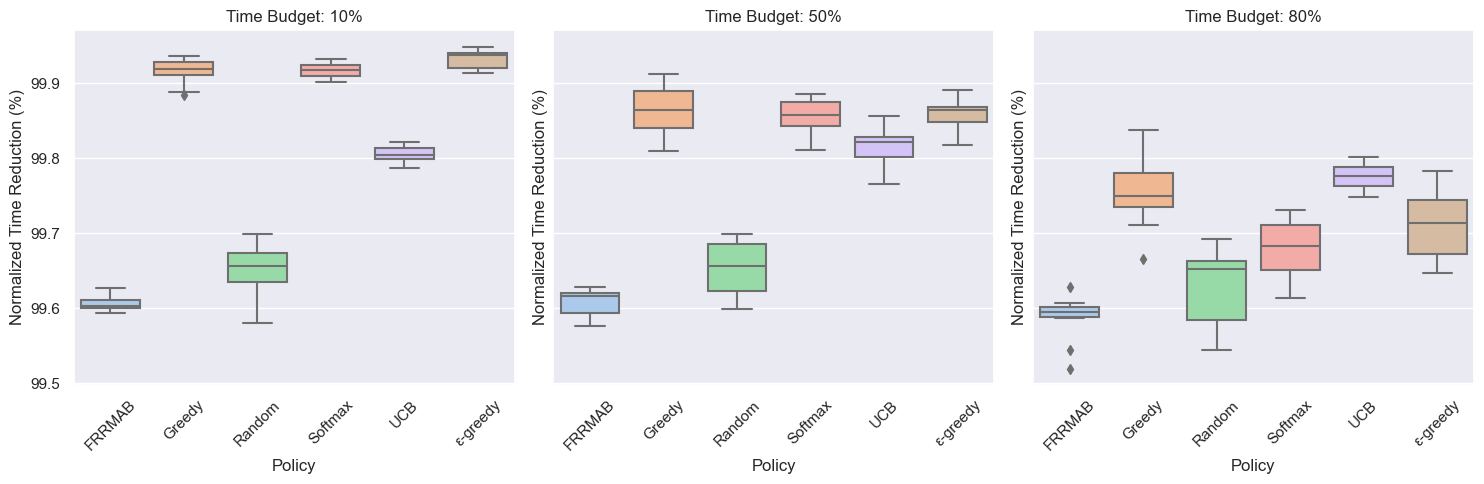

In [24]:
plot_normalize_time_reduction(scenarios=['LexisNexis'], reward_function=RewardFunction.TimeRank)

# Prioritization Time Distribution

We consider the `experiment_id` column because we want to observe the distribution (by commmit) across the independent executions.


In [25]:
%%sql mean_distribution <<
SELECT 
    scenario,
    experiment_id,
    sched_time,
    policy,
    reward_function,
    AVG(prioritization_time) AS avg_prioritization_time,
    AVG(fitness) AS avg_fitness_time,
    AVG(cost) AS avg_cost_time,
FROM filtered_data
GROUP BY scenario, experiment_id, sched_time, policy, reward_function
ORDER BY sched_time, policy, reward_function, scenario;

In [26]:
def plot_distribution(column: str, scenarios: Optional[List[str]] = None, reward_function: RewardFunction = None):
    """
    Plots the prioritization time for given scenarios and a specific reward function.

    Parameters:
    - column (str): The name of the metric column in `variation_data` to plot. This column should contain
                    the average values of the metric for each policy at each step.
    - scenarios (Optional[List[str]]): List of scenarios to filter the data. If None, all scenarios are considered.
    - reward_function (RewardFunction): The reward function to filter the data. If None, all reward functions are considered.

    This function generates a subplot for each scheduled time, displaying the prioritization time across different policies.
    """
    # Filter the data by scenario (if provided)
    df_filtered = mean_distribution[mean_distribution['scenario'].isin(scenarios)] if scenarios else mean_distribution

    # Further filter the data by reward function (if provided)
    if reward_function:
        df_filtered = df_filtered[df_filtered['reward_function'] == reward_function.name]

    # Set up the figure and axes for the subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(sched_times), sharey=True, figsize=(15, 5))

    # Ensure axes is always an array, even when there's only one subplot
    if len(sched_times) == 1:
        axes = [axes]

    metric, _ = get_metric_ylabel(column)
    
    for ax, sched_time in zip(axes, sched_times):
        # Filter the DataFrame for the current sched_time
        df_sched_time_filtered = df_filtered[df_filtered['sched_time'] == sched_time]
        
        sns.boxplot(x='policy', y=column, data=df_sched_time_filtered, ax=ax)
            
        ax.set_title(f"Time Budget: {round(sched_time*100)}%")
        ax.set_xlabel('Policy')
        ax.set_ylabel('Average Prioritization Time (seconds)')
        ax.tick_params(axis='x', rotation=45)  # Rotate policy names for better readability        

    plt.tight_layout()
    plt.show()

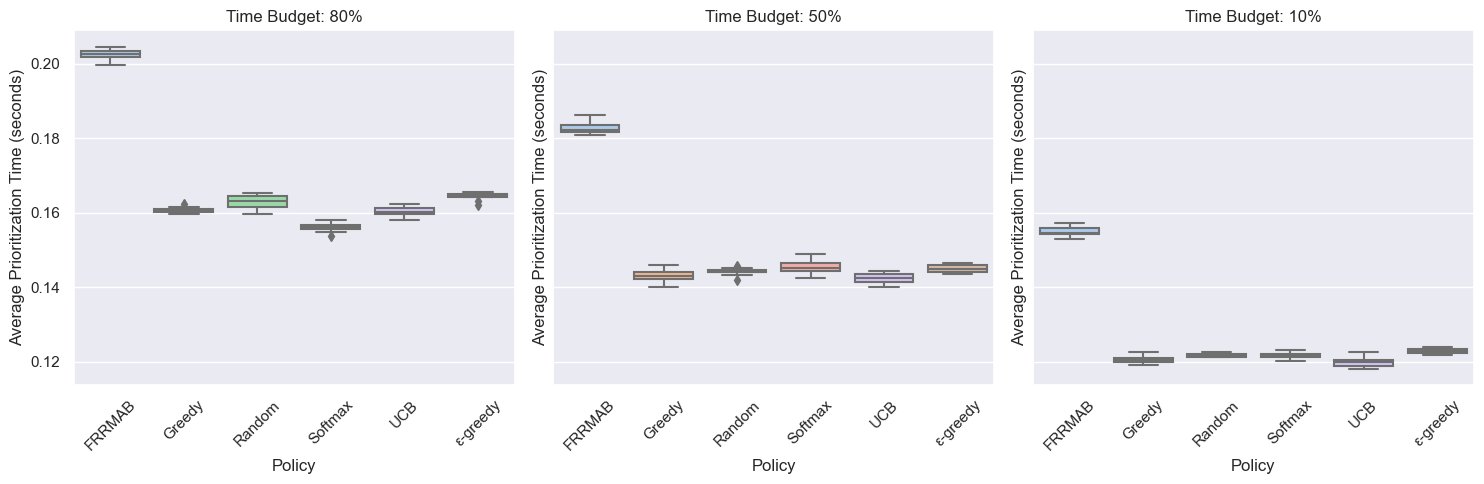

In [38]:
plot_distribution('avg_prioritization_time', scenarios=['LexisNexis'], reward_function=RewardFunction.TimeRank)

# NAPFD Distribution


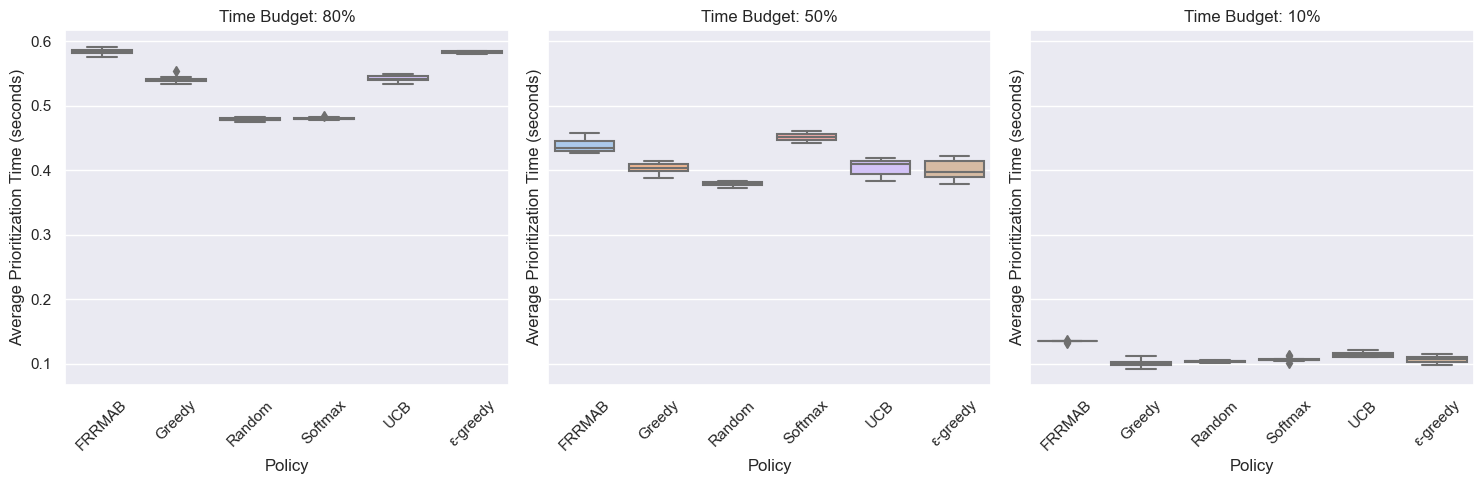

In [28]:
plot_distribution('avg_fitness_time', scenarios=['LexisNexis'], reward_function=RewardFunction.TimeRank)

# APFDc Distribution


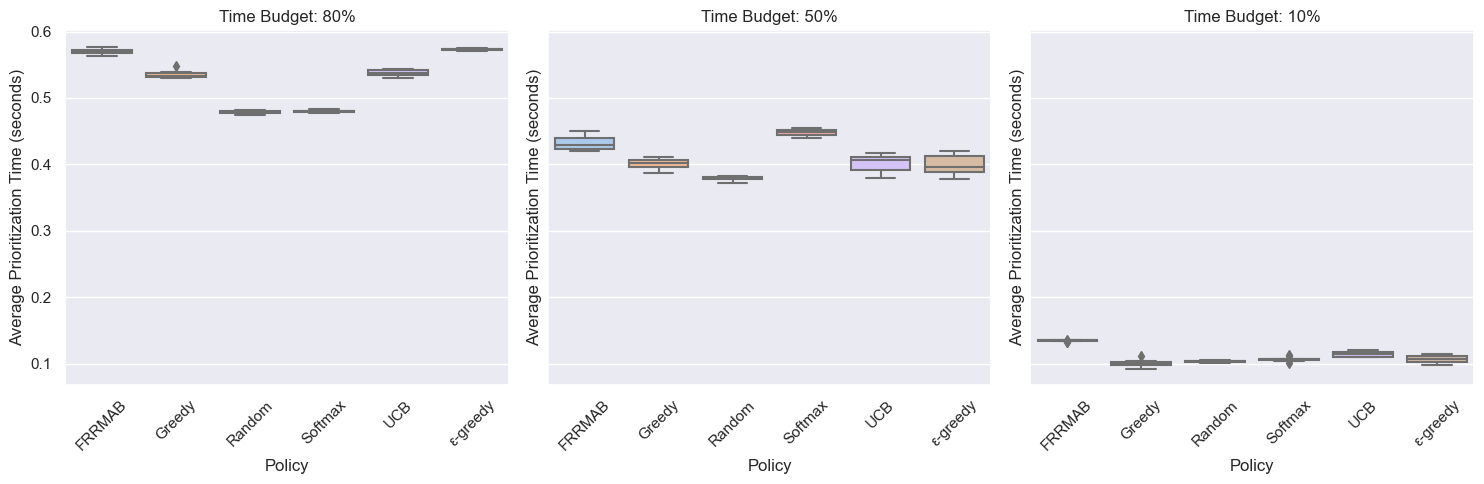

In [29]:
plot_distribution('avg_cost_time', scenarios=['LexisNexis'], reward_function=RewardFunction.TimeRank)

# Statistical Test

## Kruskal-Wallis



In [30]:
def perform_statistical_test(dataframe: pd.DataFrame, group_column: str, value_column: str, alpha: float = 0.05):
    """
    Performs the Kruskal-Wallis H-test for independent samples, follows up with the Nemenyi post-hoc test if significant,
    and computes Vargha and Delaney's A index for all pairwise comparisons.

    Parameters:   
    - dataframe (pd.DataFrame): The DataFrame containing the data. 
    - group_column (str): The name of the column in the DataFrame to group by.
    - value_column (str): The name of the column in the DataFrame containing the values to test.
    - alpha (float, optional): Significance level used to determine the critical threshold for rejecting the null hypothesis. Defaults to 0.05.


    Returns:
    - A dictionary with Kruskal-Wallis test results and, if applicable, Nemenyi post-hoc test results.
      - kruskal_stat (float): The test statistic.
      - kruskal_pvalue (float): The p-value for the test.
      - all_equivalent (bool): True if the test fails to reject the null hypothesis (indicating no significant difference between group medians), False otherwise.
      - nemenyi_posthoc (pd.DataFrame or None): The result of the Nemenyi post-hoc test if p_value < alpha; None otherwise.
      - vda_result (pd.DataFrame): The Vargha and Delaney's A index for all pairwise comparisons.


    """
    groups = dataframe.groupby(group_column)[value_column].apply(list).values
    stat, p_value = kruskal(*groups)

    all_equivalent = p_value >= alpha
    posthoc_result = None

    # If the Kruskal-Wallis test is significant, proceed with the Nemenyi post-hoc test
    if not all_equivalent:                                 
        # Perform Nemenyi post-hoc test
        posthoc_result = posthocs.posthoc_nemenyi(dataframe, 
                                                  val_col=value_column, 
                                                  group_col=group_column)                
        
    # Compute Vargha and Delaney's A index for all pairwise comparisons
    vda_result = vargha_delaney.VD_A_DF(dataframe, val_col=value_column, group_col=group_column)
    
    return {
        'kruskal_stat': stat,
        'kruskal_pvalue': p_value,
        'all_equivalent': all_equivalent,
        'nemenyi_posthoc': posthoc_result,
        'vda_result': vda_result
    }

In [31]:
def calculate_policy_statistics(df, column, direction='max'):
    """
    Calculates statistical measures for each policy and identifies the best policy based on a specified metric.

    This function computes the mean, standard deviation, maximum, and minimum values of a specified metric
    for each policy. It then identifies the best policy based on either the highest or lowest mean value of
    the metric, depending on the specified direction.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data to analyze.
    - column (str): The name of the column for which to calculate the statistics.
    - direction (str, optional): Determines the criteria for identifying the best policy. 
                                 Use 'max' to select the policy with the highest mean value or 'min' for the lowest. 
                                 Defaults to 'max'.

    Returns:
    - pd.DataFrame: A DataFrame containing the calculated mean, standard deviation, maximum, and minimum values for each policy.
    - str: The name of the best policy based on the specified direction.

    Example:
    >>> data = {'policy': ['A', 'B', 'A', 'B'], 'metric': [1, 2, 3, 4]}
    >>> df = pd.DataFrame(data)
    >>> stats_df, best_policy = calculate_policy_statistics(df, 'metric', 'max')
    >>> print(stats_df)
    >>> print("Best policy:", best_policy)
    """
    # Calculate mean, std, max, and min for each policy
    stats = df.groupby(['policy'], as_index=False).agg(
        {column: ['mean', 'std', 'max', 'min']})
    
    stats.columns = ['policy', 'mean', 'std', 'max', 'min']

    # Round values for presentation
    stats = stats.round({'mean': 4, 'std': 3, 'max': 4, 'min': 4})
    
    best_policy = stats.loc[stats['mean'].idxmax() if direction == 'max' else stats['mean'].idxmin(), 'policy']
        
    return stats, best_policy

### LaTeX conversion (to be used in papers)

In [32]:
def determine_effect_size_symbol(policy: str, best_policy: str, effect_size_df: pd.DataFrame) -> str:
    """
    Determines the effect size symbol for a given policy compared to the best policy.

    Parameters:
    - policy (str): The policy for which the effect size symbol is determined.
    - best_policy (str): The policy considered as the best based on some criteria.
    - effect_size_df (pd.DataFrame): DataFrame containing effect size symbols between policies.

    Returns:
    - str: A LaTeX symbol representing the effect size magnitude between the given policy and the best policy.
    """
    if policy == best_policy:
        return "$\\bigstar$"
    elif effect_size_df.loc[effect_size_df.compared_with == policy, 'effect_size_symbol'].values.size > 0:
        return effect_size_df.loc[effect_size_df.compared_with == policy, 'effect_size_symbol'].values[0]
    else:
        return effect_size_df.loc[effect_size_df.base == policy, 'effect_size_symbol'].values[0]
        
def generate_latex_configuration(row: pd.Series, best_policy: str, posthoc_df: pd.DataFrame, all_equivalent: bool) -> str:
    """
    Generates LaTeX formatted text for statistical comparison results.

    Parameters:
    - row (pd.Series): A row from the DataFrame containing statistical comparison results.
    - best_policy (str): The policy considered as the best based on some criteria.
    - posthoc_df (pd.DataFrame): DataFrame containing post-hoc comparison results.
    - all_equivalent (bool): Indicates whether all policies are statistically equivalent.

    Returns:
    - str: LaTeX formatted string representing the statistical significance or equivalence.
    """
    current_policy = row['policy']

    if all_equivalent:
        return f"\\cellgray{{{row['avg_std_effect']}}}"

    if current_policy == best_policy:
        return f"\\cellbold{{{row['avg_std_effect']}}}"

    is_equivalent = False
    if posthoc_df is not None:
        if best_policy in posthoc_df.columns and current_policy in posthoc_df.index and not np.isnan(posthoc_df.loc[current_policy][best_policy]):
            is_equivalent = posthoc_df.loc[current_policy][best_policy] >= 0.05
        elif current_policy in posthoc_df.columns and best_policy in posthoc_df.index and not np.isnan(posthoc_df.loc[best_policy][current_policy]):
            is_equivalent = posthoc_df.loc[best_policy][current_policy] >= 0.05

    return f"\\cellgray{{{row['avg_std_effect']}}}" if is_equivalent else row['avg_std_effect']


### Statistical Test Procedure

In [33]:
def statistical_test_procedure(dataframe: pd.DataFrame, column: str, use_latex=False):
    """
    Conducts a statistical test procedure on a given DataFrame and column, optionally formatting the results for LaTeX.

    This function filters data by scheduled time, performs statistical tests to compare policies, calculates statistics for each policy,
    and optionally formats the results with LaTeX symbols for effect size and significance. It aggregates the results across different
    scheduled times and returns a summary DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the experiment data.
    - column (str): The name of the column in the DataFrame to perform the statistical test on.
    - use_latex (bool, optional): A flag to determine whether to format the results with LaTeX symbols. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame summarizing the statistical test results across different scheduled times, including the best policy
      and its statistics. The DataFrame includes LaTeX formatted strings if `use_latex` is True.

    The returned DataFrame columns include 'TimeBudget', policy names, and 'Metric', where 'TimeBudget' represents the scheduled time,
    policy names are dynamic based on the input data, and 'Metric' is the column name passed as an argument. Each row represents the
    aggregated results for a specific scheduled time.

    Note:
    - The function assumes 'sched_time' is a column in the input DataFrame to filter data by scheduled time.
    - The function relies on external functions `perform_statistical_test`, `calculate_policy_statistics`, `vargha_delaney.reduce`,
      `determine_effect_size_symbol`, and `generate_latex_configuration` to perform its operations.
    - The function dynamically adjusts to the policies present in the input DataFrame and formats results based on the `use_latex` flag.
    """
    stat_columns = np.insert(policies, 0, 'TimeBudget')
    df_stats = pd.DataFrame(columns=stat_columns)
    
    for sched_time in sched_times:
        # Filter the DataFrame for the current sched_time
        df_sched_time_filtered = dataframe[dataframe['sched_time'] == sched_time]

        # Apply the statistical test and posthoc
        statistical_results = perform_statistical_test(df_sched_time_filtered, 'policy', column)

        # Identify the best policy and statistics for each policy
        stats, best_policy = calculate_policy_statistics(df_sched_time_filtered, column)
        
        df_reduced = vargha_delaney.reduce(statistical_results['vda_result'], best_policy)

        if use_latex:
            # Get a LaTeX symbol for the effect size result
            stats['eff_symbol'] = stats.apply(lambda x: determine_effect_size_symbol(x['policy'], best_policy, df_reduced), axis=1)

            # Concat the values to a single column
            stats['avg_std_effect'] = stats.apply(lambda row: f"{row['mean']:.4f} $\\pm$ {row['std']:.4f} {row['eff_symbol']}".strip(), axis=1)

            # Add LaTeX config for the best (bold) and equivalents (gray) to the best one
            stats['latex_format'] = stats.apply(lambda row: generate_latex_configuration(row, 
                                                                                        best_policy, 
                                                                                        statistical_results['nemenyi_posthoc'], 
                                                                                        statistical_results['all_equivalent']), axis=1)

        # Select the main information
        stats_trans = stats[['policy', 'latex_format']].copy() if use_latex else  stats[['policy', 'mean']].copy() 
        stats_trans.index = stats['policy']
        stats_trans = stats_trans.transpose()

        # Drop the first row
        stats_trans = stats_trans.drop(stats_trans.index[0])

        row = stats_trans.values[0]

        row = np.insert(row, 0, sched_time)

        df_stats = pd.concat([df_stats, pd.DataFrame([row], columns=np.append('TimeBudget', stats_trans.columns.values))], ignore_index=True)

    df_stats['Metric'] = column

    return df_stats   

### Prioritization Time

In [34]:
df_stats = statistical_test_procedure(mean_distribution, 'avg_prioritization_time')
df_stats

,TimeBudget,UCB,Softmax,Random,FRRMAB,Greedy,ε-greedy,Metric
0,0.8,0.0898,0.0919,0.0950,0.1273,0.0902,0.0946,avg_prioritization_time
1,0.5,0.0852,0.0863,0.0868,0.1209,0.0857,0.0883,avg_prioritization_time
2,0.1,0.0781,0.0772,0.0813,0.1145,0.0790,0.0825,avg_prioritization_time


### NAPFD

In [35]:
df_stats = statistical_test_procedure(mean_distribution, 'avg_fitness_time')
df_stats

,TimeBudget,UCB,Softmax,Random,FRRMAB,Greedy,ε-greedy,Metric
0,0.8,0.7989,0.7607,0.7240,0.8337,0.7984,0.8081,avg_fitness_time
1,0.5,0.7602,0.7398,0.6865,0.7787,0.7482,0.7523,avg_fitness_time
2,0.1,0.6276,0.5951,0.5793,0.6554,0.6180,0.6254,avg_fitness_time


### APFDc

In [36]:
df_stats = statistical_test_procedure(mean_distribution, 'avg_cost_time')
df_stats

,TimeBudget,UCB,Softmax,Random,FRRMAB,Greedy,ε-greedy,Metric
0,0.8,0.8171,0.7750,0.7253,0.8438,0.8181,0.8230,avg_cost_time
1,0.5,0.7891,0.7628,0.6879,0.7963,0.7804,0.7772,avg_cost_time
2,0.1,0.6487,0.6096,0.5796,0.6796,0.6423,0.6483,avg_cost_time
